### Download and import libraries

In [1]:
!pip3 install -U spacy
!pip3 install -U spacy-Lookups-data
# !python3 -m spacy download en_core_web_sm 
# !python3 -m spacy download en_core_web_md
# !python3 -m spacy download en_core_web_lg

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


#### Import related packages and set up plotter function .

In [2]:
# Importing Related Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
nltk.download('stopwords')
nltk.download('punkt')
import string

import re
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS


import pathlib
import shutil
import tempfile
from  IPython import display

import os

result_df = pd.DataFrame(columns = ['model', 'F1_score'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prakash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/prakash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# # Loading Tensorboard
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
# #print(logdir)
# shutil.rmtree(logdir, ignore_errors=True)

# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# os.environ['TENSORBOARD_BINARY'] = '/Users/prakash/Library/Python/3.8/bin/tensorboard'
# # Open an embedded TensorBoard viewer
# %tensorboard --logdir {logdir}/models

In [4]:
# Plotter Function to plot performance of models

from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

# Input data
Used read_csv function to read the training as well as test data into dataframes. Train data has 1999 values of 6 different features while test data has 755 values of 6 features.

In [5]:
# Reading Training and Test datasets
train_data = "twitter_ethereum_annotated_stance_train.csv"
test_data = "twitter_ethereum_annotated_stance_test.csv"
traindata = pd.read_csv(train_data, engine='python')
testdata = pd.read_csv(test_data, engine='python')
print(traindata.shape)
print(testdata.shape)

(1999, 6)
(755, 6)


In [6]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1999 non-null   float64
 1   data    1999 non-null   object 
 2   stance  1999 non-null   object 
 3   date    1999 non-null   object 
 4   user    1999 non-null   object 
 5   target  1999 non-null   object 
dtypes: float64(1), object(5)
memory usage: 93.8+ KB


In [7]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      755 non-null    float64
 1   data    755 non-null    object 
 2   stance  755 non-null    object 
 3   date    755 non-null    object 
 4   user    755 non-null    object 
 5   target  755 non-null    object 
dtypes: float64(1), object(5)
memory usage: 35.5+ KB


# Exploring Features

The features of the dataset are : Tweet Id, Data, stance, date, user, target. Out of which our main aim is to predict the Stance of a tweet if Tweet and Target is provided. Other features are not needed

The tweets are classified into 3 Stance values namely,

tweets that FAVOR the target value
Tweets which are AGAINST the target value
Tweets which are neither in FAVOR nor AGAINST (i.e. NONE)

In [8]:
# Value counts of tweets according to the stance

print(traindata['target'].value_counts())
print("----------------------------------------------------------")
print(traindata['stance'].value_counts())

ethereum    1999
Name: target, dtype: int64
----------------------------------------------------------
None       802
Favor      786
Against    411
Name: stance, dtype: int64


In [9]:
# Lets try to plot a graph of the above distribution to check whether there is a class imbalance issue in the dataset

Target = traindata['target'].unique().tolist()
df = pd.DataFrame(columns=['Target', 'FAVOR', 'AGAINST', 'NONE'])
for target in Target:
  data = traindata[traindata['target']==target]
  #print(data[data['Stance']=='FAVOR'].shape[0])
  df = df.append({'Target': target, 'FAVOR': data[data['stance']=='Favor'].shape[0], 'AGAINST': data[data['stance']=='Against'].shape[0], 'NONE': data[data['stance']=='None'].shape[0]}, ignore_index= True)
df

/var/folders/38/jmmjt5q90lv64896_mjyqzy40000gn/T/ipykernel_39339/510495572.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Target': target, 'FAVOR': data[data['stance']=='Favor'].shape[0], 'AGAINST': data[data['stance']=='Against'].shape[0], 'NONE': data[data['stance']=='None'].shape[0]}, ignore_index= True)


,Target,FAVOR,AGAINST,NONE
0,ethereum,786,411,802


 We can see from the  graph below the distribution of data for each stance


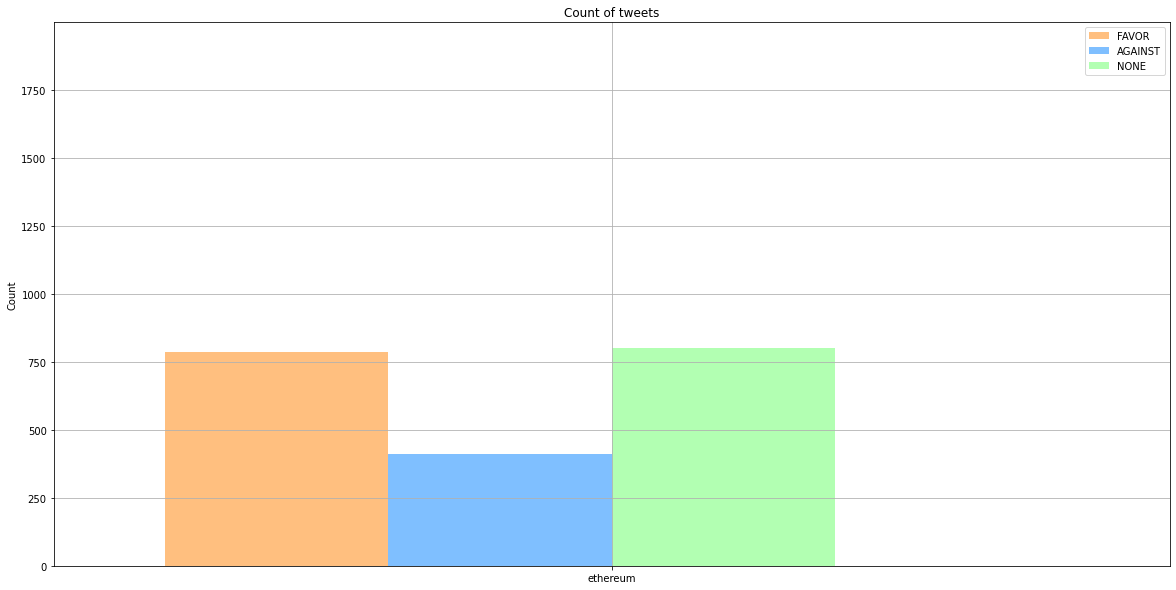

In [10]:
# Grouped bar graph for stance values of each target value.
pos = list(range(len(df['FAVOR']))) 
width = 0.25 
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(pos, df['FAVOR'], width, alpha=0.5, color='#FF8000', label=df['Target'][0]) 
plt.bar([p + width for p in pos], df['AGAINST'], width, alpha=0.5, color='#0080FF', label=df['Target'][0]) 
plt.bar([p + width*2 for p in pos], df['NONE'], width, alpha=0.5, color='#66FF66', label=df['Target'][0]) 
ax.set_ylabel('Count')
ax.set_title('Count of tweets')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(df['Target'])
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(df['FAVOR'] + df['AGAINST'] + df['NONE'])] )
plt.legend(['FAVOR', 'AGAINST', 'NONE'], loc='upper right')
plt.grid()
plt.show()

The main task is to predict the Stance of a particular tweet based on the tweet content and the target it is mentioned for.

In [11]:
# as we have to use only tweet sentences and Target as an input for detecting the Stance, we concatenate this features into a single feature 
train_data = traindata[['data','stance','target']]
train_data["Tweet"] = train_data["data"] + " " + train_data["target"]
train_data.shape

/var/folders/38/jmmjt5q90lv64896_mjyqzy40000gn/T/ipykernel_39339/3181837115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["Tweet"] = train_data["data"] + " " + train_data["target"]


(1999, 4)

## Data exploration:

Explore data by checking several counts

In [12]:
# Some more exploration about the tweets which may helps in preprocessing

# Word count in the Tweet column 

train_data['Word_Count'] = train_data['Tweet'].apply(lambda x: len(str(x).split()))


## Character Counts in Tweet column

train_data['Character_Count'] = train_data['Tweet'].apply(lambda x: len(x))


train_data.head()

/var/folders/38/jmmjt5q90lv64896_mjyqzy40000gn/T/ipykernel_39339/3073377266.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Word_Count'] = train_data['Tweet'].apply(lambda x: len(str(x).split()))


,data,stance,target,Tweet,Word_Count,Character_Count
0,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,None,ethereum,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,9,64
1,@KraZeMike83 @mattysats @_CryptoCurator @ger31...,None,ethereum,@KraZeMike83 @mattysats @_CryptoCurator @ger31...,20,154
2,» Binance Smart Chain Beats Ethereum by Some M...,Against,ethereum,» Binance Smart Chain Beats Ethereum by Some M...,18,128
3,#BinanceSmartChain handled 10M+ transactions y...,None,ethereum,#BinanceSmartChain handled 10M+ transactions y...,9,89
4,2 years ago.\n\n» Binance CEO Predicts Amazon ...,None,ethereum,2 years ago.\n\n» Binance CEO Predicts Amazon ...,19,128


In [13]:
# Calculating the average word length [calculated using formula =  (Character_Count/Word_Count)]

train_data['Average_Word_length'] = train_data['Character_Count']/train_data['Word_Count']

# Counting the stop words

train_data['Stop_words_count'] = train_data['Tweet'].apply(lambda x: len([t for t in x.split() if t in STOP_WORDS]))

train_data.head()

,data,stance,target,Tweet,Word_Count,Character_Count,Average_Word_length,Stop_words_count
0,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,None,ethereum,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,9,64,7.111111,1
1,@KraZeMike83 @mattysats @_CryptoCurator @ger31...,None,ethereum,@KraZeMike83 @mattysats @_CryptoCurator @ger31...,20,154,7.700000,4
2,» Binance Smart Chain Beats Ethereum by Some M...,Against,ethereum,» Binance Smart Chain Beats Ethereum by Some M...,18,128,7.111111,2
3,#BinanceSmartChain handled 10M+ transactions y...,None,ethereum,#BinanceSmartChain handled 10M+ transactions y...,9,89,9.888889,0
4,2 years ago.\n\n» Binance CEO Predicts Amazon ...,None,ethereum,2 years ago.\n\n» Binance CEO Predicts Amazon ...,19,128,6.736842,1


In [14]:
## Count HashTags -> # and mentions -> @

train_data['HashTag_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.startswith("#")])) 

train_data['Mention_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.startswith("@")])) 

train_data.head()

,data,stance,target,Tweet,Word_Count,Character_Count,Average_Word_length,Stop_words_count,HashTag_Count,Mention_Count
0,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,None,ethereum,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,9,64,7.111111,1,0,0
1,@KraZeMike83 @mattysats @_CryptoCurator @ger31...,None,ethereum,@KraZeMike83 @mattysats @_CryptoCurator @ger31...,20,154,7.700000,4,0,8
2,» Binance Smart Chain Beats Ethereum by Some M...,Against,ethereum,» Binance Smart Chain Beats Ethereum by Some M...,18,128,7.111111,2,0,0
3,#BinanceSmartChain handled 10M+ transactions y...,None,ethereum,#BinanceSmartChain handled 10M+ transactions y...,9,89,9.888889,0,2,0
4,2 years ago.\n\n» Binance CEO Predicts Amazon ...,None,ethereum,2 years ago.\n\n» Binance CEO Predicts Amazon ...,19,128,6.736842,1,0,0


In [15]:
## Checking the numeric digits present in the tweets

train_data['numeric_digit_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.isdigit()])) 

# Checking the count of Upper Case in the tweet (Because mostly people write in capital when they are Happy or Sad)

train_data['uppercase_Count'] = train_data['Tweet'].apply(lambda x : len([t for t in x.split() if t.isupper() and len(x)>3])) 

train_data.head()

,data,stance,target,Tweet,Word_Count,Character_Count,Average_Word_length,Stop_words_count,HashTag_Count,Mention_Count,numeric_digit_Count,uppercase_Count
0,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,None,ethereum,Bulgaria Stock Exchange Lists Bitcoin and Ethe...,9,64,7.111111,1,0,0,0,0
1,@KraZeMike83 @mattysats @_CryptoCurator @ger31...,None,ethereum,@KraZeMike83 @mattysats @_CryptoCurator @ger31...,20,154,7.700000,4,0,8,0,0
2,» Binance Smart Chain Beats Ethereum by Some M...,Against,ethereum,» Binance Smart Chain Beats Ethereum by Some M...,18,128,7.111111,2,0,0,0,0
3,#BinanceSmartChain handled 10M+ transactions y...,None,ethereum,#BinanceSmartChain handled 10M+ transactions y...,9,89,9.888889,0,2,0,0,2
4,2 years ago.\n\n» Binance CEO Predicts Amazon ...,None,ethereum,2 years ago.\n\n» Binance CEO Predicts Amazon ...,19,128,6.736842,1,0,0,1,1


# Preprocessing the tweets

In [16]:
# Converting to lower case

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: x.lower()) 

train_data['Tweet'].head(2)

0    bulgaria stock exchange lists bitcoin and ethe...
1    @krazemike83 @mattysats @_cryptocurator @ger31...
Name: Tweet, dtype: object

In [17]:
# Expand contracted words

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"cause": "because",
"could've": "could have",
"couldn't": "could not",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i had",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"o'clock": "of the clock",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she had",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they had",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'll": "you will",
"you're": "you are",
"you've": "you have",
" n ":"and",
" u ": "you",
}

def contract_to_extended(x):
  if type(x) is str:
    for key in contractions:
      value = contractions[key]
      x = x.replace(key, value)
    return x
  else:
    return x

In [18]:
#Perform expansions
train_data['Tweet'] = train_data['Tweet'].apply(lambda x: contract_to_extended(x))
train_data['Tweet'].head(5)

0    bulgaria stock exchange lists bitcoin and ethe...
1    @krazemike83 @mattysats @_cryptocurator @ger31...
2    » binance smart chain beats ethereum by some m...
3    #binancesmartchain handled 10m+ transactions y...
4    2 years ago.\n\n» binance ceo predicts amazon ...
Name: Tweet, dtype: object

In [19]:
## Count and remove emails from the tweet
import re
train_data['email'] = train_data['Tweet'].apply(lambda x: re.findall(r'([-a-zA-Z0-9._-]+@[-a-zA-Z0-9._-]+\.[-a-zA-Z0-9_-]+)',x))

In [20]:
# Counting the number of email present in the dataset 

train_data['email_count'] = train_data['email'].apply(lambda x: len(x))

# Checking if the emails are greater that 1

train_data[train_data['email_count']>0]

,data,stance,target,Tweet,Word_Count,Character_Count,Average_Word_length,Stop_words_count,HashTag_Count,Mention_Count,numeric_digit_Count,uppercase_Count,email,email_count
216,You need to work well under pressure and be se...,Favor,ethereum,you need to work well under pressure and be se...,48,281,5.854167,18,2,0,0,3,[talent@realvision.com],1


In [21]:
## Removing the emails from the Tweet column.

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: re.sub(r'([-a-zA-Z0-9._-]+@[-a-zA-Z0-9._-]+\.[-a-zA-Z0-9_-]+)','',x))

In [22]:
## Removing Special characters and punctuations

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: re.sub('[^A-Za-z0-9#@]+',' ',x))

## Remove the multiple(extra) spaces

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: " ".join(x.split()))

## Remove the Accented characters (e.g. àÿüûâ)
import unicodedata

def remove_accent(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('utf-8','ignore')
  return x

## Applying on tweets
train_data['Tweet'] = train_data['Tweet'].apply(lambda x: remove_accent(x))

### Removing the stop words

train_data['Tweet'] = train_data['Tweet'].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))


train_data['Tweet'].head(5)

0    bulgaria stock exchange lists bitcoin ethereum...
1    @krazemike83 @mattysats @ cryptocurator @ger31...
2    binance smart chain beats ethereum metrics tha...
3    #binancesmartchain handled 10m transactions ye...
4    2 years ago binance ceo predicts amazon coin c...
Name: Tweet, dtype: object

In [23]:
## Convert the tweets into a list 
train_text = train_data['Tweet'].tolist()
train_text[:3]

['bulgaria stock exchange lists bitcoin ethereum etns ethereum',
 '@krazemike83 @mattysats @ cryptocurator @ger313 @twitterspaces @binance @ethereum @solana joined spaces 1st time today cuz tweet ethereum',
 'binance smart chain beats ethereum metrics thanks latest gamefi craze coindesk https t co uag05i7i1k ethereum']

In [24]:
## Get dummies for the stance values
y_data = train_data['stance']
y_data = pd.get_dummies(y_data).values
y_data.shape

(1999, 3)

In [25]:
## Tokenize the tweets using Keras tokenizer
from keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(train_text)

## Calculating the vocabulary size
vocab_size = len(token.word_index)+1
vocab_size

9111

In [26]:
## Encode the text
encoded_text = token.texts_to_sequences(train_text)
print(encoded_text[:3])

## Used max length of 155
## By default prepadding is done

sentence_max_length = 155
X_data = pad_sequences(encoded_text, maxlen=sentence_max_length)
print(X_data.shape)
X_data

[[3879, 767, 289, 1871, 5, 1, 3880, 1], [3881, 3882, 3883, 3884, 3885, 166, 1, 15, 1872, 3886, 1205, 22, 25, 3887, 413, 1], [166, 30, 29, 2462, 1, 1206, 114, 183, 3888, 1028, 490, 4, 2, 3, 3889, 1]]
(1999, 155)


array([[   0,    0,    0, ...,    1, 3880,    1],
       [   0,    0,    0, ..., 3887,  413,    1],
       [   0,    0,    0, ...,    3, 3889,    1],
       ...,
       [   0,    0,    0, ...,    3, 9106,    1],
       [   0,    0,    0, ..., 1761, 3486,    1],
       [   0,    0,    0, ..., 3465, 1776,    1]], dtype=int32)

# Word embedding

Since the dataset is small, used a pretrained vector weights to use better representation of the vocabulary  in the data set
Used Glove Twitter 100 dimensional pretrained vector present on https://nlp.stanford.edu/projects/glove/

File can be found in the following google drive link:
https://drive.google.com/drive/folders/1RbdLXLmjLkNyY49M37czowGTwt--TI0p?usp=sharing

In [27]:
##### Glove Vector
# e.g. hello -0.11 0.23 0.333 0.54 0.65
glove_vectors = dict()
file = open('glove.twitter.27B.100d.txt', encoding='utf-8')
glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

In [28]:
### Prints the length of keys in glove vector dictionary
print(len(glove_vectors.keys()))

#### displaying the shape of the glove vector just for testing purpose
print(glove_vectors.get('to').shape)

1193514
(100,)


In [29]:
#Create Embedded Matrix by mapping each word in dataset with the same word in the Glove Vector. 
#The words which are not in the Glove vector are added to the list named 'Not_words'.
E_T = np.zeros((vocab_size , 100))
Not_words = list()
for word, i in token.word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:  
        E_T[i] = embedding_vector
    else:
      #print(word) # Printing the misspelled words
      Not_words.append(word)

print("Embedding Matrix size: ", E_T.size)
print("Words which are not in Embedding Matrix: ", len(Not_words))

Embedding Matrix size:  911100
Words which are not in Embedding Matrix:  3071


In [30]:
Not_words

['ethereum',
 '2',
 '1',
 '3',
 'vitalikbuterin',
 'bebecause',
 '0',
 'nfts',
 'blockchains',
 '5',
 'cardano',
 'eth2',
 'coinmarketcap',
 '000',
 'vitalik',
 '10',
 'consensys',
 '4',
 '7',
 'uniswap',
 'binance',
 '2021',
 'notgrubles',
 'filecoin',
 '6',
 '30',
 'usdc',
 '2017',
 '1559',
 '0jqlpc2l1v',
 'stablecoins',
 'antiprosynth',
 'tuurdemeester',
 'cryptoiq',
 'udiwertheimer',
 'l2',
 'ryansadams',
 '2020',
 '12',
 '20',
 'l1',
 'mainnet',
 'bobsummerwill',
 '100',
 '2018',
 'iohk',
 'ethereumjoseph',
 '8',
 '9',
 '50',
 'lightningnetwork',
 'gladstein',
 'web3',
 'kylesamani',
 'bitcoiners',
 'altcoin',
 'hxcpjbyuzq',
 'erc20',
 '0xpolygon',
 'infura',
 'bhec39',
 'bitcoincoreorg',
 'aeyakovenko',
 'aantonop',
 'bytemaster7',
 'petermccormack',
 '2016',
 'cburniske',
 'opfzcstjsx',
 'adam3us',
 'blockstream',
 'alexsaundersau',
 'excellion',
 'hotepjesus',
 'vinarmani',
 'maximalists',
 'odrpemwso9',
 'permissionless',
 'erikvoorhees',
 'apompliano',
 'thorchain',
 'bobmcel

In [31]:
## Split the data into training and validation sets with 80, 20 split using sklearn
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (1599, 155)
y_train shape:  (1599, 3)
X_val shape:  (400, 155)
y_val shape:  (400, 3)


## Model

Created a baseline model with Transfer Learning layer.

Architechture :
1> encoded input is fed to the Glove pretrained vector to create an Embedding Layer weights. 
2> Embedding Layer with the weights generated above is created as the first layer of the model. 
3> Output of the first layer is given to the LSTM layer with 32 memory units which has dropout rate of 0.5 and recurrent_dropout rate of 0.25. 
4> Output of LSTM layer is again passed through the dropout layer of 0.6 value. 
5> The output of above dropout layer is fed to the ReLU dense layer of 64 unit for the non-linear activation. 
6> Above output is again passed though the dropuout layer of 0.6 value 
7> Final layer is the Softmax activation layer with 3 output units which predict the Stance as either 'FAVOR', 'AGAINST' or 'NONE'.
8> 'categorical_crossentropy' : error metric and 
  'Categorical_Accuracy' : performance metric 
  'adam': optimizer for the training purpose.

In [32]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers
import keras.backend as K
import numpy as np
 
def create_model(embedding_layer):

  model_glove = Sequential()
  model_glove.add(embedding_layer)
  model_glove.add(LSTM(units=32, dropout=0.5, recurrent_dropout= 0.25))
  #model_glove.add(LSTM(units=64, kernel_regularizer=regularizers.l2(0.01)))
  model_glove.add(Dropout(0.6))
  model_glove.add(Dense(64, activation='relu'))
  model_glove.add(Dropout(0.4))
  model_glove.add(Dense(3, activation='softmax'))
  model_glove.compile(loss='categorical_crossentropy', optimizer='adam')

  return model_glove  

Create model using the above function with embedding layers using glove weights

In [33]:
vector_size = 100
embedding_layer = Embedding( vocab_size,
                     vector_size,
                     input_length=155,
                     weights=[E_T],
                     trainable=False)
model1 = create_model(embedding_layer)
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 155, 100)          911100    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dropout (Dropout)           (None, 32)                0         


2022-04-21 11:22:27.432520: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 930,431
Trainable params: 19,331
Non-trainable params: 911,100
_________________________________________________________________
None


In [34]:
def get_callbacks(name):
  return [
    tf.keras.callbacks.TensorBoard(logdir/name, histogram_freq=1),
  ]

In [35]:
#The batch size is set to 64 and training was done for 24 epochs and 3 folds. 
#Model saved into a dictionary

m_models = {}
m_models['Golve_with_TL'] = model1.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), callbacks=get_callbacks('models/Golve_with_TL'), verbose=1)   


Epoch 1/50
25/25 [==============================] - 7s 158ms/step - loss: 1.0828 - val_loss: 1.0571
Epoch 2/50
25/25 [==============================] - 4s 141ms/step - loss: 1.0600 - val_loss: 1.0436
Epoch 3/50
25/25 [==============================] - 4s 147ms/step - loss: 1.0571 - val_loss: 1.0362
Epoch 4/50
25/25 [==============================] - 4s 150ms/step - loss: 1.0384 - val_loss: 1.0262
Epoch 5/50
25/25 [==============================] - 4s 150ms/step - loss: 1.0264 - val_loss: 1.0145
Epoch 6/50
25/25 [==============================] - 4s 149ms/step - loss: 1.0117 - val_loss: 0.9850
Epoch 7/50
25/25 [==============================] - 4s 151ms/step - loss: 0.9981 - val_loss: 0.9625
Epoch 8/50
25/25 [==============================] - 4s 147ms/step - loss: 0.9847 - val_loss: 0.9405
Epoch 9/50
25/25 [==============================] - 4s 151ms/step - loss: 0.9593 - val_loss: 0.9074
Epoch 10/50
25/25 [==============================] - 4s 148ms/step - loss: 0.9354 - val_loss: 0.9036

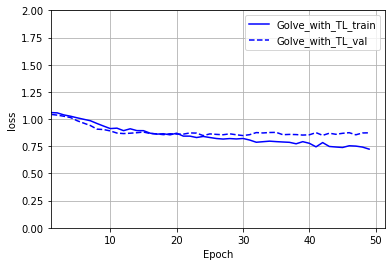

In [36]:
##To check the learning curve of the training and validation we plot the grphs using plotter function mentioned above.
plotter(m_models, ylim=[0.0, 2], metric = 'loss')

## Evaluation on test data

In [37]:
testdata

,id,data,stance,date,user,target
0,1.440000e+18,Ethereum is the open social network of the fut...,Favor,2021-09-24 22:27:15+00:00,FEhrsam,ethereum
1,1.400000e+18,"This is exactly what happened with Bitcoin, Et...",None,2021-06-01 00:02:27+00:00,FEhrsam,ethereum
2,1.380000e+18,Yet crypto kept building. @ethereum came on th...,Favor,2021-04-14 08:02:25+00:00,FEhrsam,ethereum
3,1.300000e+18,“It’s no secret that the Ethereum blockchain i...,Against,2020-08-28 21:30:43+00:00,FEhrsam,ethereum
4,1.260000e+18,Early experiments in people selling equity in ...,None,2020-05-06 05:09:16+00:00,FEhrsam,ethereum
...,...,...,...,...,...,...
750,1.230000e+18,Govt lawyers are seldom concerned for the shar...,Against,2020-02-19 14:15:49+00:00,rogerkver,ethereum
751,1.210000e+18,Don't like something? Don't buy it.\nHave som...,None,2019-12-15 23:41:14+00:00,rogerkver,ethereum
752,1.090000e+18,This is the kind of attitude everyone should h...,Favor,2019-01-31 14:34:04+00:00,rogerkver,ethereum
753,9.800000e+17,"#BTC a year ago 300k txs, now 170k\n#LTC a yea...",None,2018-03-31 22:06:41+00:00,rogerkver,ethereum


#### Preprocess test data similar to train data

In [38]:
def preprocessing(data):
   data = data[['data','stance','target']]
   data["Tweet"] = data["data"] + " " +data["target"]
   data['Tweet'] = data['Tweet'].apply(lambda x: x.lower()) 
   data['Tweet'] = data['Tweet'].apply(lambda x: contract_to_extended(x))
   data['Tweet'] = data['Tweet'].apply(lambda x: re.sub(r'([-a-zA-Z0-9._-]+@[-a-zA-Z0-9._-]+\.[-a-zA-Z0-9_-]+)','',x))
   data['Tweet'] = data['Tweet'].apply(lambda x: re.sub('[^A-Za-z0-9#@]+',' ',x))
   data['Tweet'] = data['Tweet'].apply(lambda x: " ".join(x.split()))
   data['Tweet'] = data['Tweet'].apply(lambda x: remove_accent(x))
   data['Tweet'] = data['Tweet'].apply(lambda x: " ".join([t for t in x.split() if t not in STOP_WORDS]))
   text = data['Tweet'].tolist()
   return text

test_text = preprocessing(testdata)

/var/folders/38/jmmjt5q90lv64896_mjyqzy40000gn/T/ipykernel_39339/1053680737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Tweet"] = data["data"] + " " +data["target"]
/var/folders/38/jmmjt5q90lv64896_mjyqzy40000gn/T/ipykernel_39339/1053680737.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Tweet'] = data['Tweet'].apply(lambda x: x.lower())
/var/folders/38/jmmjt5q90lv64896_mjyqzy40000gn/T/ipykernel_39339/1053680737.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [39]:
## Get dummies for stance in test data
y_test = testdata['stance']
y_test = pd.get_dummies(y_test).values
y_test.shape

(755, 3)

In [40]:
## Tokenize the test tweets
from keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(test_text)
encoded_text = token.texts_to_sequences(test_text)
X_test = pad_sequences(encoded_text, maxlen=sentence_max_length)

In [41]:
## Predict stance for test data
predict_x=model1.predict(X_test) 
y_pred_test=np.argmax(predict_x,axis=1)

In [42]:
predict_x

array([[0.13521567, 0.5148216 , 0.34996268],
       [0.07263265, 0.7514763 , 0.17589113],
       [0.01128834, 0.83454436, 0.15416728],
       ...,
       [0.01157076, 0.67506707, 0.3133622 ],
       [0.70687073, 0.08216374, 0.21096559],
       [0.02002071, 0.3519652 , 0.6280141 ]], dtype=float32)

In [43]:
## Use sklearn to calculate f1 score on test data
from sklearn.metrics import f1_score
y_true = np.argmax(y_test, axis= 1)

f1_score_result = f1_score(y_true, y_pred_test,average='weighted')
result_df.loc[len(result_df)] = ['Model_with_TL', f1_score_result]
f1_score_result

0.501602998839643

In [44]:
## Tokenizing and padding the Tweets data to make it suitable for further modelling.

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_LENGTH = 155
embedding_dim = 100

def Padding(Tweets):  
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(Tweets)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  X = tokenizer.texts_to_sequences(Tweets)
  X = pad_sequences(X, maxlen=MAX_LENGTH, padding= 'post')
  print('Shape of data tensor:', X.shape)

  return X, word_index

In [45]:
X_data, word_index = Padding(train_text)
Y_data = pd.get_dummies(train_data['stance']).values
print('Shape of label tensor:', Y_data.shape)

Found 9110 unique tokens.
Shape of data tensor: (1999, 155)
Shape of label tensor: (1999, 3)


In [46]:
embedding_layer2 = Embedding(len(word_index)+1,
                                   embedding_dim,
                                   input_length=MAX_LENGTH,
                                   trainable=True)
model2 = create_model(embedding_layer2)
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 155, 100)          911100    
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 930,431
Trainable params: 930,431
Non-tr

In [47]:
from sklearn.model_selection import KFold
num_folds = 3
input = np.concatenate((X_train, X_val), axis= 0)
target = np.concatenate((y_train, y_val), axis= 0)

kfold = KFold(n_splits=num_folds, shuffle=True)
K = 1
for train, test in kfold.split(input, target):
    print("fold number: ", K)

    m_models['without_TL'] = model2.fit(input[train], target[train], batch_size=32, epochs=20, validation_data=(input[test], target[test]), callbacks=get_callbacks('models/without_TL'), verbose=1)
    K = K+1

fold number:  1
Epoch 1/20
42/42 [==============================] - 10s 179ms/step - loss: 1.0774 - val_loss: 1.0638
Epoch 2/20
42/42 [==============================] - 7s 171ms/step - loss: 1.0522 - val_loss: 1.0502
Epoch 3/20
42/42 [==============================] - 7s 164ms/step - loss: 1.0092 - val_loss: 1.0245
Epoch 4/20
42/42 [==============================] - 7s 167ms/step - loss: 0.8627 - val_loss: 1.0322
Epoch 5/20
42/42 [==============================] - 7s 165ms/step - loss: 0.5884 - val_loss: 1.0944
Epoch 6/20
42/42 [==============================] - 7s 165ms/step - loss: 0.3031 - val_loss: 1.4351
Epoch 7/20
42/42 [==============================] - 7s 174ms/step - loss: 0.1684 - val_loss: 1.5823
Epoch 8/20
42/42 [==============================] - 7s 171ms/step - loss: 0.0965 - val_loss: 2.2696
Epoch 9/20
42/42 [==============================] - 7s 168ms/step - loss: 0.0586 - val_loss: 2.4749
Epoch 10/20
42/42 [==============================] - 7s 167ms/step - loss: 0.0501 -

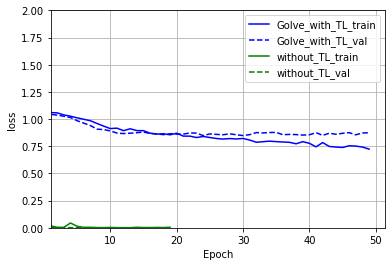

In [48]:
plotter(m_models, ylim=[0.0, 2], metric = 'loss')

In [63]:
X_test, test_word_index = Padding(test_text)
Y_true = pd.get_dummies(testdata['stance']).values
print('Shape of label tensor:', Y_true.shape)

Found 4144 unique tokens.
Shape of data tensor: (755, 155)
Shape of label tensor: (755, 3)


In [64]:
## Get dummies for stance in test data
y_test = testdata['stance']
y_test = pd.get_dummies(y_test).values
y_test.shape

(755, 3)

In [67]:
## Predict stance for test data
predict_x=model2.predict(X_test) 

y_pred_test=np.argmax(predict_x,axis=1)

Y_true = np.argmax(y_test, axis=1)

f1_score_result = f1_score(Y_true, y_pred_test, average='micro')
result_df.loc[len(result_df)] = ['model_without_TL', f1_score_result]
f1_score_result

0.3788079470198675

In [62]:
result_df

,model,F1_score
0,Model_with_TL,0.501603
1,model_without_TL,0.378808
